# Config

In [ ]:
# Libraries
import geopandas as gpd
import pandas as pd

import h3
from shapely.geometry import Polygon
from config import INTERIM_DATA_DIR,
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import osmnx as ox
import shapely

In [ ]:
# Params
CITY = "barcelona"
RES = 10


# Load data

In [3]:
# Get city boundaries using osmnx
city_polygon = ox.geocode_to_gdf(CITY)
gdf = gpd.GeoDataFrame(geometry=city_polygon['geometry'], crs="EPSG:4326")
print(f"Loaded boundary for {CITY}")

Loaded boundary for barcelona


# Data management (Code)

## Make h3 Grid of network

6920 H3 cells covering the network boundary.


<Axes: >

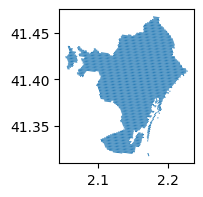

In [7]:
# Get the convex hull of the whole network
network_union = unary_union(gdf.geometry)
network_boundary = network_union
network_boundary
geojson = network_boundary.__geo_interface__
# Make h3 grid
shape = h3.geo_to_h3shape(geojson)
cells_id = h3.polygon_to_cells(shape, RES)
# Create a GeoDataFrame with the H3 cells
cells_df = pd.DataFrame(cells_id, columns=["h3_id"])
cells_df["geometry"] = cells_df["h3_id"].apply(
    lambda h: Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(h)])
)
cells_gdf = gpd.GeoDataFrame(cells_df, geometry="geometry", crs="EPSG:4326")

print(f"{len(cells_gdf)} H3 cells covering the network boundary.")
cells_gdf.plot(figsize=(2, 2))

## Reproject and make spatial indexes

In [8]:
# Reproject both to a metric CRS
gdf = gdf.to_crs(epsg=25831)
cells_gdf = cells_gdf.to_crs(epsg=25831)

# Make spatial index
gdf_sindex = gdf.sindex
cells_sindex = cells_gdf.sindex

# Plots

<Axes: >

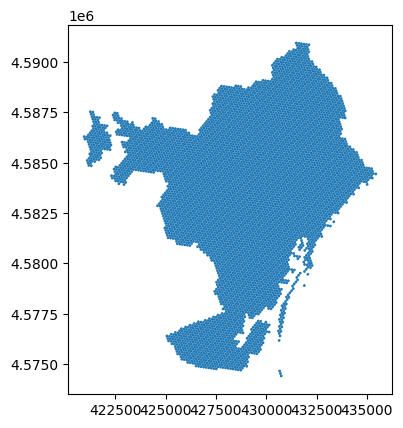

In [11]:
cells_gdf.plot()

# Save results

In [12]:
#Save results and figures
cells_gdf.to_parquet(INTERIM_DATA_DIR / f"{CITY}_h3_res{RES}.parquet")